DATA COLLECTION

In [1]:
import requests
import os

url = 'https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip'
downloads_folder = os.path.join(os.path.expanduser('~'), 'Downloads')
output_file = os.path.join(downloads_folder, 'cats-and-dogs.zip')

try:
    response = requests.get(url)
    
    # Check if the request was successful (status code 200)
    if response.status_code == 200:
        with open(output_file, 'wb') as f:
            f.write(response.content)
        print(f"File downloaded to {output_file}")
    else:
        print(f"Failed to download file: HTTP status code {response.status_code}")

except requests.exceptions.RequestException as e:
    print(f"Error downloading file: {e}")

Failed to download file: HTTP status code 404


download manually from:

https://www.microsoft.com/en-us/download/confirmation.aspx?id=54765

In [2]:
import zipfile

local_zip = r"C:\Users\karat\Downloads\kagglecatsanddogs_5340.zip"
extract_dir = r"C:\Users\karat\Downloads\kagglecatsanddogs_5340"

os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(local_zip, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"Contents extracted to: {extract_dir}")

Contents extracted to: C:\Users\karat\Downloads\kagglecatsanddogs_5340


In [3]:
cats = r"C:\Users\karat\Downloads\kagglecatsanddogs_5340\PetImages\Cat\\"
dogs = r"C:\Users\karat\Downloads\kagglecatsanddogs_5340\PetImages\Dog\\"
print(len(os.listdir(cats)))
print(len(os.listdir(dogs))) 

12501
12501


In [4]:
import random
import os
from shutil import copyfile

dir = r"C:\Users\karat\Downloads\kagglecatsanddogs_5340"

try:
    os.makedirs(os.path.join(dir, 'cats-v-dogs', 'training', 'cats'))
    os.makedirs(os.path.join(dir, 'cats-v-dogs', 'testing', 'cats'))
    os.makedirs(os.path.join(dir, 'cats-v-dogs', 'training', 'dogs'))
    os.makedirs(os.path.join(dir, 'cats-v-dogs', 'testing', 'dogs'))
except OSError:
    pass

def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    files = []
    for filename in os.listdir(SOURCE):
        file = os.path.join(SOURCE, filename)
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")

    training_length = int(len(files) * SPLIT_SIZE)
    testing_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[training_length:]

    for filename in training_set:
        this_file = os.path.join(SOURCE, filename)
        destination = os.path.join(TRAINING, filename)
        copyfile(this_file, destination)

    for filename in testing_set:
        this_file = os.path.join(SOURCE, filename)
        destination = os.path.join(TESTING, filename)
        copyfile(this_file, destination)

CAT_SOURCE_DIR = os.path.join(dir, "PetImages", "Cat")
TRAINING_CATS_DIR = os.path.join(dir, "cats-v-dogs", "training", "cats")
TESTING_CATS_DIR = os.path.join(dir, "cats-v-dogs", "testing", "cats")
DOG_SOURCE_DIR = os.path.join(dir, "PetImages", "Dog")
TRAINING_DOGS_DIR = os.path.join(dir, "cats-v-dogs", "training", "dogs")
TESTING_DOGS_DIR = os.path.join(dir, "cats-v-dogs", "testing", "dogs")

split_size = 0.9
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)

666.jpg is zero length, so ignoring.
11702.jpg is zero length, so ignoring.


In [5]:
training_cats_dir = os.path.join(dir, 'cats-v-dogs', 'training', 'cats')
training_dogs_dir = os.path.join(dir, 'cats-v-dogs', 'training', 'dogs')
testing_cats_dir = os.path.join(dir, 'cats-v-dogs', 'testing', 'cats')
testing_dogs_dir = os.path.join(dir, 'cats-v-dogs', 'testing', 'dogs')

print(len(os.listdir(training_cats_dir)))
print(len(os.listdir(training_dogs_dir)))
print(len(os.listdir(testing_cats_dir)))
print(len(os.listdir(testing_dogs_dir)))


12377
12372
2377
2372


MODEL BUILDING

In [6]:
import tensorflow as tf
print(tf.__version__)

2.16.1


In [7]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [8]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
]) 


model.compile(
            optimizer=Adam(0.001),
            loss='binary_crossentropy', 
            metrics=['accuracy']
            )

c:\Users\karat\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [9]:
training_loc = r"C:\Users\karat\Downloads\kagglecatsanddogs_5340\cats-v-dogs\training"
train_datagen = ImageDataGenerator(rescale=1.0/255.,
                                    rotation_range=40,               
                                    width_shift_range=0.2,          
                                    height_shift_range=0.2,          
                                    shear_range=0.2,                 
                                    zoom_range=0.2,                 
                                    horizontal_flip=True,            
                                    fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(training_loc,
                                                    batch_size=100,
                                                    class_mode='binary',
                                                    target_size=(150, 150))
 
valid_loc = r"C:\Users\karat\Downloads\kagglecatsanddogs_5340\cats-v-dogs\testing"
validation_datagen = ImageDataGenerator(rescale=1.0/255.)
validation_generator = validation_datagen.flow_from_directory(valid_loc,
                                                              batch_size=100,
                                                              class_mode='binary',
                                                              target_size=(150, 150))

Found 22498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


In [10]:
history = model.fit(train_generator,
                    epochs=8,
                    verbose=1,
                    validation_data=validation_generator)

Epoch 1/8
225/225 ━━━━━━━━━━━━━━━━━━━━ 228s 991ms/step - accuracy: 0.5725 - loss: 0.7134 - val_accuracy: 0.7452 - val_loss: 0.5194
Epoch 2/8
225/225 ━━━━━━━━━━━━━━━━━━━━ 216s 939ms/step - accuracy: 0.7603 - loss: 0.4950 - val_accuracy: 0.7996 - val_loss: 0.4339
Epoch 3/8
225/225 ━━━━━━━━━━━━━━━━━━━━ 205s 900ms/step - accuracy: 0.8168 - loss: 0.4064 - val_accuracy: 0.7984 - val_loss: 0.4374
Epoch 4/8
225/225 ━━━━━━━━━━━━━━━━━━━━ 217s 953ms/step - accuracy: 0.8522 - loss: 0.3413 - val_accuracy: 0.8228 - val_loss: 0.4105
Epoch 5/8
225/225 ━━━━━━━━━━━━━━━━━━━━ 273s 1s/step - accuracy: 0.8869 - loss: 0.2714 - val_accuracy: 0.8260 - val_loss: 0.3920
Epoch 6/8
225/225 ━━━━━━━━━━━━━━━━━━━━ 221s 972ms/step - accuracy: 0.9224 - loss: 0.1965 - val_accuracy: 0.8248 - val_loss: 0.4190
Epoch 7/8
225/225 ━━━━━━━━━━━━━━━━━━━━ 215s 940ms/step - accuracy: 0.9518 - loss: 0.1288 - val_accuracy: 0.8360 - val_loss: 0.4945
Epoch 8/8
225/225 ━━━━━━━━━━━━━━━━━━━━ 229s 1s/step - accuracy: 0.9790 - loss: 0.0675 

<Figure size 640x480 with 0 Axes>

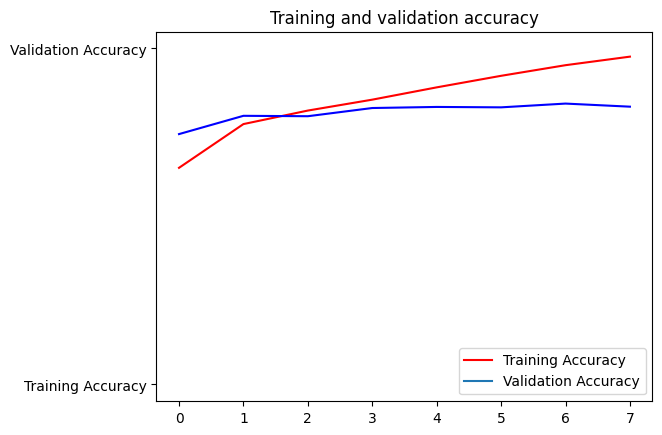

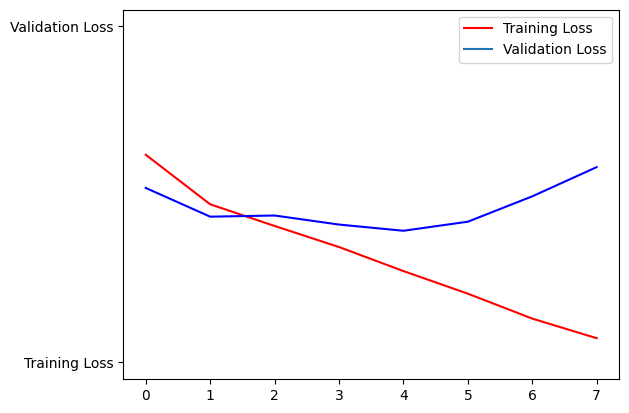

<Figure size 640x480 with 0 Axes>

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']
 
epochs=range(len(acc))
 
#plotting accuracy
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.legend(["Training Accuracy", "Validation Accuracy"])
plt.figure()

# plotting loss
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.legend(["Training Loss", "Validation Loss"])
plt.figure()

In [13]:
import os

In [16]:
import numpy as np
from PIL import Image
from keras.preprocessing import image

directory = r"C:\Users\karat\Downloads\testing_images_for_model"

image_files = [file for file in os.listdir(directory) if file.endswith(('jpg', 'jpeg', 'png'))]

for file in image_files:
    img_path = os.path.join(directory, file)

    img = Image.open(img_path).convert("RGB")
    img = img.resize((150, 150))
    
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = x / 255.0
    
    classes = model.predict(x)
    
    if classes[0] > 0.5:
        print(f"{file} is a dog")
    else:
        print(f"{file} is a cat")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
download_c.jpeg is a cat
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
download_c2.jpeg is a cat
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
download_c3.jpeg is a cat
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
download_d.jpeg is a dog
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
download_d2.jpeg is a cat
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
download_d3.jpeg is a dog
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
download_d4.jpeg is a dog
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
images_c.jpeg is a dog
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
images_c2.jpeg is a dog
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
images_d.jpeg is a dog
